# Casting Quality Control<a id='Casting Quality Control'></a>

## 2. Data Wrangling and EDA<a id='Data Wrangling and EDA'></a>

* [2.1 Introduction](#2.1_Introduction)
* [2.2 Package Importing](#2.2_Package_Importing)
* [2.3 Data Exploratory](#2.3_Data_Exploratory)
  * [2.3.1 Data Dictionary](#2.3.1_Data_Dictionary)
  * [2.3.2 Image counts](#2.3.2_Image_counts)
  * [2.3.3 Defective Percentage](#2.3.3_Defective_Percentage)
  * [2.3.4 Image Exploratory](#2.3.4_Image_Exploratory)
* [2.4 Data Preparation](#2.4_Data_Preparation)
  * [2.4.1 Data Arrangement](#2.4.1_Data_Arrangement)
  * [2.4.2 Image Resize](#2.4.2_Image_Resize)
  * [2.4.3 Image Color Check](#2.4.3_Image_Color_Check)
  * [2.4.4 Subset Adjustment](#2.4.4_Subset_Adjustment)
* [2.5 Summary](#2.5_Summary)

## 2.1 Introduction<a id='2.1_Introduction'></a>

This dataset centers around products from the casting manufacturing industry. Casting is a process where liquid material is poured into a mold that has a hollow cavity in the shape of the final product, and is then allowed to solidify. The main purpose for collecting this data is to analyze and find solutions for casting defects, which are unwanted irregularities that can occur during the metal casting process. Types of defects include blow holes, pinholes, burrs, shrinkage defects, and metallurgical defects, among others.

The dataset comprises 7,348 grey-scaled images of submersible pump impellers viewed from the top. Each image is 300x300 pixels in size, with image augmentation already applied. Additionally, the dataset includes a set of 512x512 pixel grey-scaled images without augmentation, consisting of 519 ‘ok_front’ (non-defective) and 781 ‘def_front’ (defective) impeller images. Stable lighting, ensured through special arrangements, was crucial for capturing these images.

Data Source: https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product

The objective of this project is to develop a classification model using the labeled images provided in the dataset, aiming to predict product quality in future manufacturing projects.

## 2.2 Package Importing<a id='2.2_Package_Importing'></a>

In [1]:
# Import basic packages for data wrangling and EDA
import numpy as np
import pandas as pd
import os
import shutil
import glob
import random
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# set random state
np.random.seed(42)

## 2.3 Data Exploratory <a id='2.3_Data_Exploratory'></a>

#### 2.3.1 Data Dictionary<a id='2.3.1_Data_Dictionary'></a>

In [3]:
def list_directories(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * level
        print('{}{}/'.format(indent, os.path.basename(root)))

# Call the function with your base directory
list_directories('Data/')

/
casting_data/
    casting_data/
        test/
            def_front/
            ok_front/
        train/
            def_front/
            ok_front/
casting_512x512/
    casting_512x512/
        def_front/
        ok_front/


The dataset comprises images categorized into two classes: 'def_front' for defective products and 'ok_front' for non-defective products. The non-augmented images are pre-split into 'test' and 'train' directories. The augmented images, which are not pre-split, will be designated for use as either testing or validation data sets.

#### 2.3.2 Image counts <a id='2.3.2_Image_counts'></a>

In [4]:
# Function to get the sizes of all images in a directory
def get_image_sizes(path):
    sizes = {}
    for image_name in os.listdir(path):
        if image_name.lower().endswith('.jpeg'):
            image_path = os.path.join(path, image_name)
            with Image.open(image_path) as img:
                size = img.size  # Size is a tuple (width, height)
                if size in sizes:
                    sizes[size] += 1
                else:
                    sizes[size] = 1
    return sizes

# Define base directories
base_dir_300x300 = 'Data/casting_data/casting_data/'
base_dir_512x512 = 'Data/casting_512x512/casting_512x512/'

# Define the subdirectories
subdirs = ['train/ok_front', 'train/def_front', 'test/ok_front', 'test/def_front']
subdirs_512 = ['ok_front', 'def_front']

# Loop through each 300 subdirectory and print the number of images and their sizes
for subdir in subdirs:
    path = os.path.join(base_dir_300x300, subdir)
    sizes = get_image_sizes(path)
    num_images = sum(sizes.values())
    print(f"There are {num_images} images in the directory: {path}")
    for size, count in sizes.items():
        print(f"Size: {size}, Count: {count}")

# Loop through each 512 subdirectory and print the number of images and their sizes
for subdir in subdirs_512:
    path = os.path.join(base_dir_512x512, subdir)
    sizes = get_image_sizes(path)
    num_images = sum(sizes.values())
    print(f"There are {num_images} images in the directory: {path}")
    for size, count in sizes.items():
        print(f"Size: {size}, Count: {count}")

There are 2875 images in the directory: Data/casting_data/casting_data/train/ok_front
Size: (300, 300), Count: 2875
There are 3758 images in the directory: Data/casting_data/casting_data/train/def_front
Size: (300, 300), Count: 3758
There are 262 images in the directory: Data/casting_data/casting_data/test/ok_front
Size: (300, 300), Count: 262
There are 453 images in the directory: Data/casting_data/casting_data/test/def_front
Size: (300, 300), Count: 453
There are 519 images in the directory: Data/casting_512x512/casting_512x512/ok_front
Size: (512, 512), Count: 519
There are 781 images in the directory: Data/casting_512x512/casting_512x512/def_front
Size: (512, 512), Count: 781


#### 2.3.3 Defective Percentage <a id='2.3.3_Defective_Percentage'></a>

In [5]:
train_ok_count = 2875
train_def_count = 3758
test_ok_count = 262
test_def_count = 453
NonA_ok_count = 519
NonA_def_count = 781

train_total_count = train_ok_count + train_def_count
test_total_count = test_ok_count + test_def_count
NonA_total_count = NonA_ok_count + NonA_def_count
Overall_total_count = train_total_count + test_total_count + NonA_total_count

train_percentage = train_total_count / Overall_total_count
test_percentage = test_total_count / Overall_total_count
NonA_percentage = NonA_total_count / Overall_total_count

train_def_rate = train_def_count / train_total_count
test_def_rate = test_def_count / test_total_count
NonA_def_rate = NonA_def_count / NonA_total_count

print(f"Training Set Size: {train_total_count}, Set Percentage: {round(train_percentage,4)}, Defective Percentage: {round(train_def_rate, 4)}")
print(f"Testing Set Size: {test_total_count}, Set Percentage: {round(test_percentage,4)}, Defective Percentage: {round(test_def_rate, 4)}")
print(f"Non-Augmented set Size: {NonA_total_count}, Set Percentage: {round(NonA_percentage,4)}, Defective Percentage: {round(NonA_def_rate, 4)}")

Training Set Size: 6633, Set Percentage: 0.767, Defective Percentage: 0.5666
Testing Set Size: 715, Set Percentage: 0.0827, Defective Percentage: 0.6336
Non-Augmented set Size: 1300, Set Percentage: 0.1503, Defective Percentage: 0.6008


The percentage of defective images varies between the training, testing, and non-augmented sets, but the variation is within an acceptable range of 56.67% to 60.08%. This indicates a relatively consistent distribution of defective samples across different subsets of the data.

#### 2.3.4 Image Exploratory  <a id='2.3.4_Image_Exploratory'></a>

Displaying images in directory: Data/casting_data/casting_data/train/ok_front


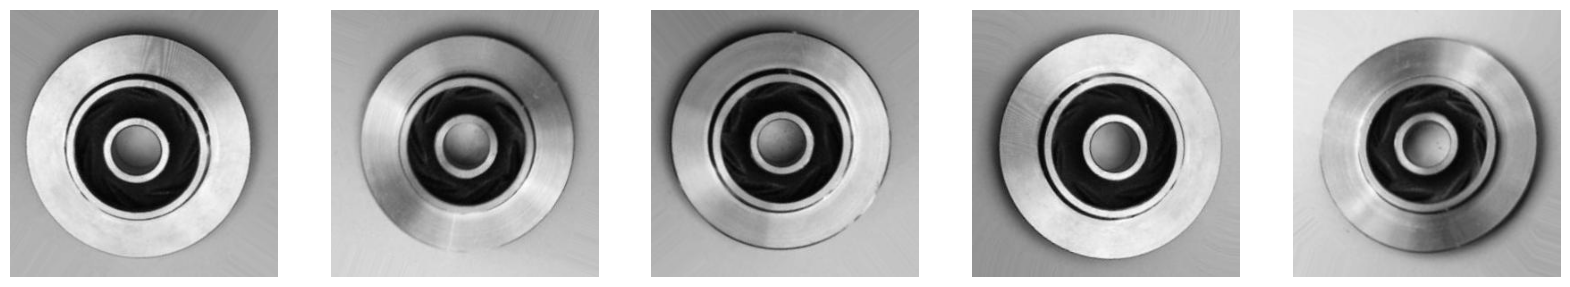

Displaying images in directory: Data/casting_data/casting_data/train/def_front


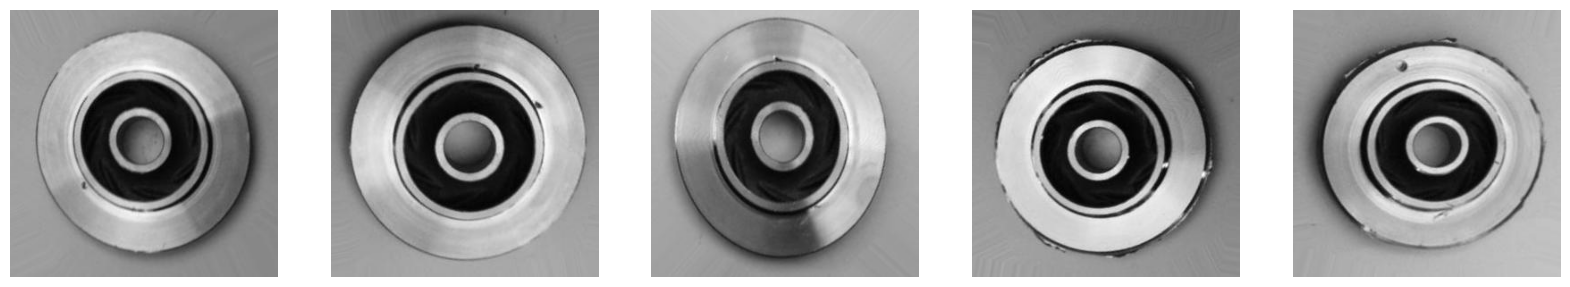

Displaying images in directory: Data/casting_data/casting_data/test/ok_front


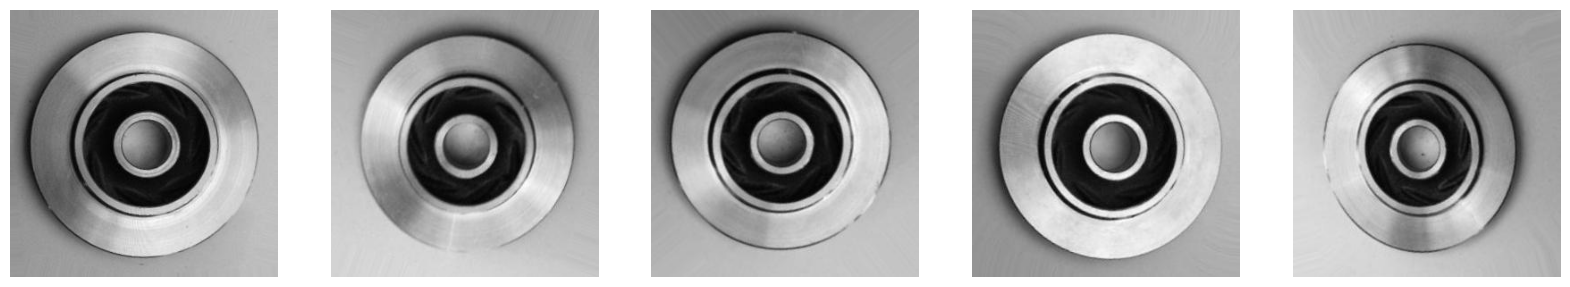

Displaying images in directory: Data/casting_data/casting_data/test/def_front


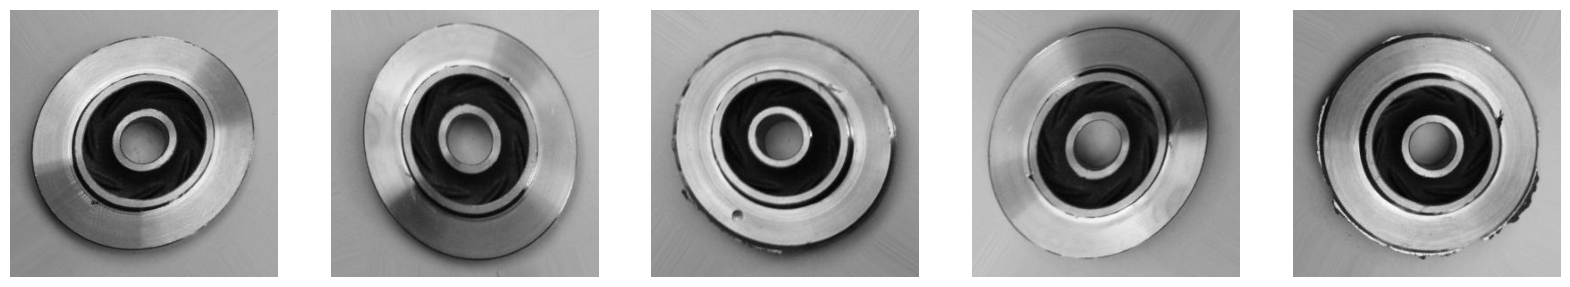

Displaying images in directory: Data/casting_512x512/casting_512x512/ok_front


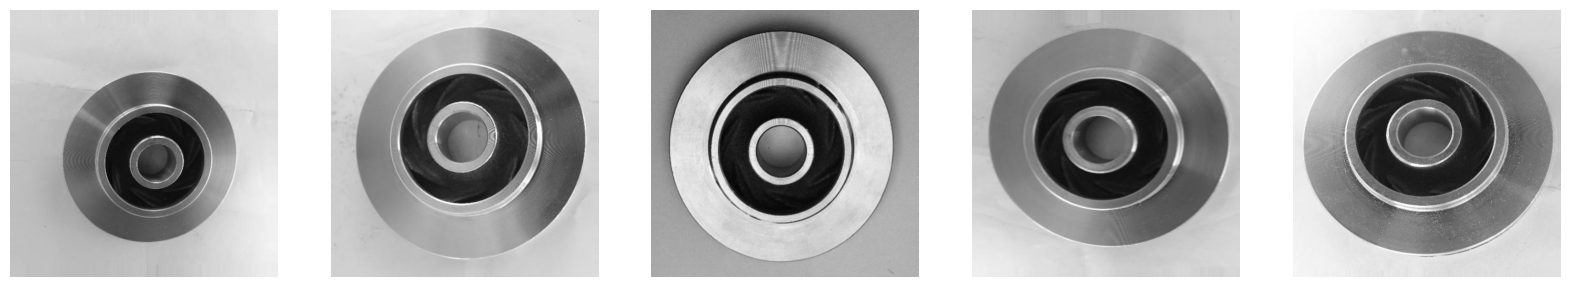

Displaying images in directory: Data/casting_512x512/casting_512x512/def_front


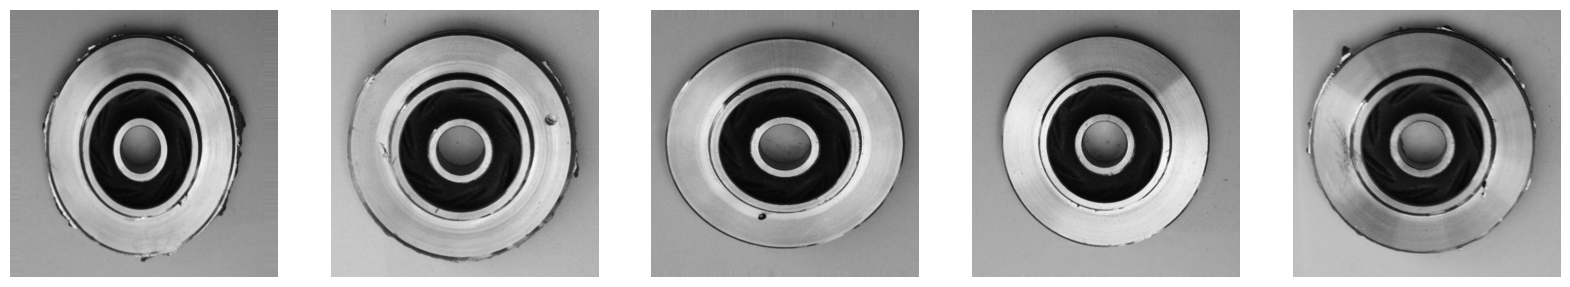

In [6]:
# Function to display images in a directory
def display_images(path, num_images=5):
    image_files = os.listdir(path)
    image_files = [img for img in image_files if img.lower().endswith('.jpeg')]
    if len(image_files) < num_images:
        print(f"Not enough images to display in {path}. There are only {len(image_files)} images.")
        num_images = len(image_files)
    
    plt.figure(figsize=(20, 10))
    for i, image_file in enumerate(image_files[:num_images]):
        img_path = os.path.join(path, image_file)
        img = Image.open(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    plt.show()

# Define base directories
base_dir_300x300 = 'Data/casting_data/casting_data/'
base_dir_512x512 = 'Data/casting_512x512/casting_512x512/'

# Define the subdirectories
subdirs = ['train/ok_front', 'train/def_front', 'test/ok_front', 'test/def_front']
subdirs_512 = ['ok_front', 'def_front']

# Display images for each 300 subdirectory
for subdir in subdirs:
    path = os.path.join(base_dir_300x300, subdir)
    print(f"Displaying images in directory: {path}")
    display_images(path)
    
# Display images for each 512 subdirectory
for subdir in subdirs_512:
    path = os.path.join(base_dir_512x512, subdir)
    print(f"Displaying images in directory: {path}")
    display_images(path)

The dataset consists of top-view images of submersible pump impellers but they were not captured at a perfect 90-degree angle. Each image is in grayscale with a round boundary and features multiple concentric circles. The dataset captures a variety of casting defects, including blowholes, pinholes, burrs, shrinkage defects, mould material defects, pouring metal defects, and metallurgical defects, among others.

Some images appear to have been augmented with techniques such as random rotation, zoom, or flipping. Width and height shifts may not be appropriate as the images were taken with the intent of centering the circle in the middle of the image frame. Applying random brightness adjustments is not suitable since it could compromise the consistency of lighting conditions, which is essential for capturing these images. Such inconsistencies could potentially affect the accuracy of the machine learning model's performance in defect detection.

## 2.4 Data Preparation <a id='2.4_Data_Preparation'></a>

#### 2.4.1 Data Arrangement  <a id='2.4.1_Data_Arrangement'></a>

To prevent confusion for those who may revisit this project in the future, it's important to establish a well-organized file structure. The names of the folders should accurately represent their respective data subsets. Accordingly, the folders should be appropriately named or created for the training, testing, and validation sets.
 
* The 'train' folder will remain as the designated Training set.  
* The 'test' folder will be repurposed as the Validation set and will be renamed to 'validation'.  
* The non-augmented '512' folder will serve as the new Testing set.

In [7]:
# To replicate the result, please run this cell after unzipping the original data file.
os.rename('Data/casting_data/casting_data', 'Data/casting_data/front_image_300x300')
os.rename('Data/casting_data/front_image_300x300/test', 'Data/casting_data/front_image_300x300/validation')
os.rename('Data/casting_data/front_image_300x300/validation/def_front', 'Data/casting_data/front_image_300x300/validation/defective')
os.rename('Data/casting_data/front_image_300x300/validation/ok_front', 'Data/casting_data/front_image_300x300/validation/ok')
os.rename('Data/casting_data/front_image_300x300/train/def_front', 'Data/casting_data/front_image_300x300/train/defective')
os.rename('Data/casting_data/front_image_300x300/train/ok_front', 'Data/casting_data/front_image_300x300/train/ok')

#### 2.4.2 Image Resize  <a id='2.4.2_Image_Resize'></a>

Non-augmented images with a resolution of 512x512 should be resized to 300x300 to align with the augmented image set.

In [8]:
# Function to resize any size images down to 300x300 and save them to a new folder

def resize_images(source_dir, target_dir, size=(300, 300)):
    # Create the target directory if it doesn't exist
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    
    # Get all jpeg images in the source directory
    images = glob.glob(os.path.join(source_dir, '*.jpeg'))
    
    for image_path in images:
        img = Image.open(image_path)
        img = img.resize(size, Image.LANCZOS)
        
        # Extract the image name from the path
        image_name = os.path.basename(image_path)
        
        # Save the resized image to the target directory
        img.save(os.path.join(target_dir, image_name))

# Define the paths to the source and target directories
source_dirs = ['Data/casting_512x512/casting_512x512/ok_front/', 'Data/casting_512x512/casting_512x512/def_front/']
target_dirs = ['Data/casting_data/front_image_300x300/test/ok/', 'Data/casting_data/front_image_300x300/test/defective/']

# Resize images in both 'ok_front' and 'def_front' directories
for source_dir, target_dir in zip(source_dirs, target_dirs):
    resize_images(source_dir, target_dir)

#### 2.4.3 Image Color Check  <a id='2.4.3_Image_Color_Check'></a>

All images are supposed to be grayscale based on the description, but a function will convert any non-grayscale images to ensure future model training is conducted properly.

In [3]:
def convert_to_grayscale_and_save(directory):
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            # Check for image files
            if file.lower().endswith('.jpeg'):
                filepath = os.path.join(subdir, file)
                # Open the image file
                with Image.open(filepath) as img:
                    # Convert the image to grayscale
                    grayscale_img = img.convert('L')
                    # Save the grayscale image back to filepath
                    grayscale_img.save(filepath)

# Convert training, validation, and test images to grayscale
convert_to_grayscale_and_save('Data/casting_data/front_image_300x300/train')
convert_to_grayscale_and_save('Data/casting_data/front_image_300x300/validation')
convert_to_grayscale_and_save('Data/casting_data/front_image_300x300/test')

In [9]:
# Call the function with your base directory
list_directories('Data/casting_data/')

/
front_image_300x300/
    train/
        defective/
        ok/
    validation/
        defective/
        ok/
    test/
        ok/
        defective/


After resizing the non-augmented images and saving them in the new 'test' folder, we have established a new file structure comprised of three folders: 'train', 'validation', and 'test'.

#### 2.4.4 Subset Adjustment  <a id='2.4.4_Subset_Adjustment'></a>

From the preceding steps, we've calculated the percentage each set represents of the total dataset:

* Training Set: 6633 images (76.7%),
* Validation Set: 715 images (8.27%),
* Testing Set: 1300 images (15.03%).

To address the size discrepancy between the Validation and Testing sets, and to balance the representation of non-augmented images, we will be transferring a portion of the Testing set to the Validation set. This adjustment will not only align the sizes of these sets more closely but will also enhance the variation within the Validation set with additional non-augmented images.

In [10]:
# Function to randomly move images
def move_random_images(source_dir, target_dir, num_to_move):
    images = os.listdir(source_dir)
    random_images = random.sample(images, num_to_move)

    for image in random_images:
        src_path = os.path.join(source_dir, image)
        dst_path = os.path.join(target_dir, image)
        shutil.move(src_path, dst_path)

# Move images to the validation directory
move_random_images('Data/casting_data/front_image_300x300/test/ok', 'Data/casting_data/front_image_300x300/validation/ok', 120)
move_random_images('Data/casting_data/front_image_300x300/test/defective', 'Data/casting_data/front_image_300x300/validation/defective', 180)

In [11]:
# Function to get the sizes of all images in a directory
def get_image_sizes(path):
    sizes = {}
    for image_name in os.listdir(path):
        if image_name.lower().endswith('.jpeg'):
            image_path = os.path.join(path, image_name)
            with Image.open(image_path) as img:
                size = img.size  # Size is a tuple (width, height)
                if size in sizes:
                    sizes[size] += 1
                else:
                    sizes[size] = 1
    return sizes

In [12]:
# Define directories
base_dir = 'Data/casting_data/front_image_300x300/'
subdirs = ['train', 'validation', 'test']
labels = ['defective', 'ok']


# Loop through each folder and print the number of images and their sizes
for subdir in subdirs:
    for label in labels:
        path = os.path.join(base_dir, subdir, label)
        sizes = get_image_sizes(path)
        num_images = sum(sizes.values())
        print(f"{subdir} , {label} ")
        for size, count in sizes.items():
            print(f"Size: {size}, Count: {count}")

train , defective 
Size: (300, 300), Count: 3758
train , ok 
Size: (300, 300), Count: 2875
validation , defective 
Size: (300, 300), Count: 622
validation , ok 
Size: (300, 300), Count: 379
test , defective 
Size: (300, 300), Count: 601
test , ok 
Size: (300, 300), Count: 399


## 2.5 Summary <a id='2.5_Summary'></a>

Following the completion of Data Wrangling and Exploratory Data Analysis, the dataset has been resized and partitioned into three distinct subsets: 'train', 'validation', and 'test'. The 'train' subset, which includes augmented images, makes up 76.7% of the data. The 'test' subset, composed solely of non-augmented images, and the 'validation' subset, which is partially augmented, each account for 11.6% of the total data. Each subset is organized into two categories labeled 'defective' and 'ok', with the defective class constituting approximately 60% of the dataset. Moving forward, we will utilize these sets to process data and train classification models.